In [9]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.calibration import calibration_curve
import wandb
import joblib

In [10]:
# Initialize WandB
wandb.init(
    project="Random_Forest_Model",
    config={
        "architecture": "Random Forest",
        "dataset": "play-by-play-regular-season-2016-2019",
        "test_size": 0.2,
        "random_state": 42,
        "n_estimators": 100,
        "max_depth": 10,
    },
)

val_accuracy,▁
val_accuracy,0.90643


In [11]:
# Load dataset
play_by_play_path = "../../../data/dataframe_2016_to_2019.csv"
play_by_play = pd.read_csv(play_by_play_path)

# Filter for regular-season games and remove missing values
play_by_play = play_by_play.loc[play_by_play["gameType"] == "regular-season"].dropna()

# Remove non-relevant features
X = play_by_play.drop(play_by_play.columns[[1, 2, 3, 5, 6, 14, 15, 16, 18, 19, 20, 21]], axis=1)
features_to_encode = ["previousEventType", "shotType"]

# Encode categorical features
def encode_and_bind(df, feature):
    dummies = pd.get_dummies(df[feature], prefix=feature)
    return pd.concat([df.drop(columns=feature), dummies], axis=1)

# Apply encoding on selected features
for feature in features_to_encode:
    X = encode_and_bind(X, feature)

y = play_by_play["isGoal"].values

# Split dataset into training and validation sets
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=wandb.config["random_state"])


### Preprocessing

In [12]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)

### Train

In [13]:
# Train Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=wandb.config["n_estimators"],
    max_depth=wandb.config["max_depth"],
    random_state=wandb.config["random_state"]
)
model.fit(X_train, y_train)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train, model.predict(X_train))

# Log training accuracy to WandB
wandb.log({"train_accuracy": train_accuracy})

### Evaluate

In [14]:
# Validate the model
y_pred_probs = model.predict_proba(X_validate)[:, 1]
y_pred = model.predict(X_validate)
val_accuracy = accuracy_score(y_validate, y_pred)

# Log validation metrics
wandb.log({"val_accuracy": val_accuracy})

# Save model
wandb_path = wandb.run.dir
model_path = f"{wandb_path}/RandomForest_Model.pkl"
joblib.dump(model, model_path)

# Log the model artifact to WandB
artifact = wandb.Artifact(name="RandomForest_Model", type="model")
artifact.add_file(model_path)
wandb.log_artifact(artifact)


<Artifact RandomForest_Model>

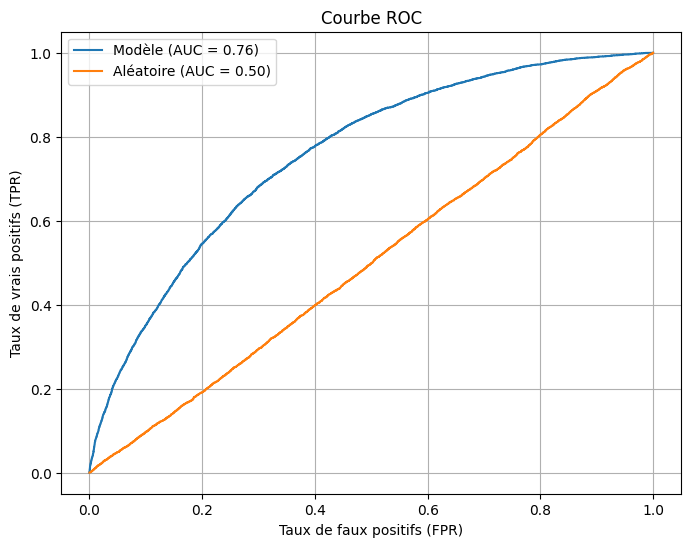

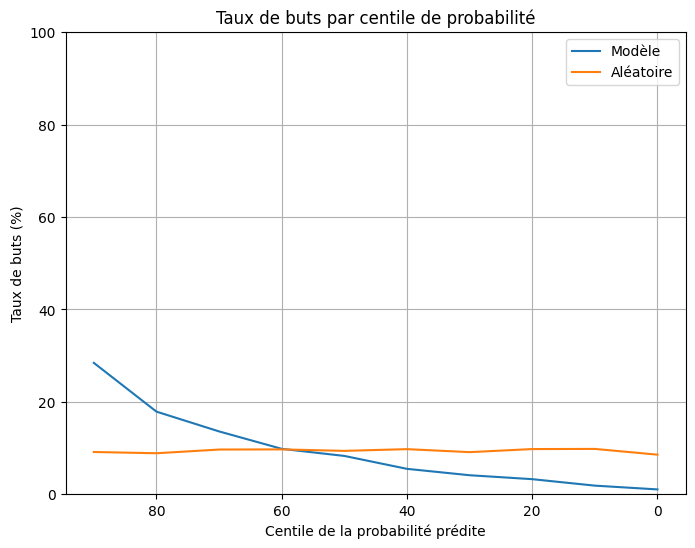

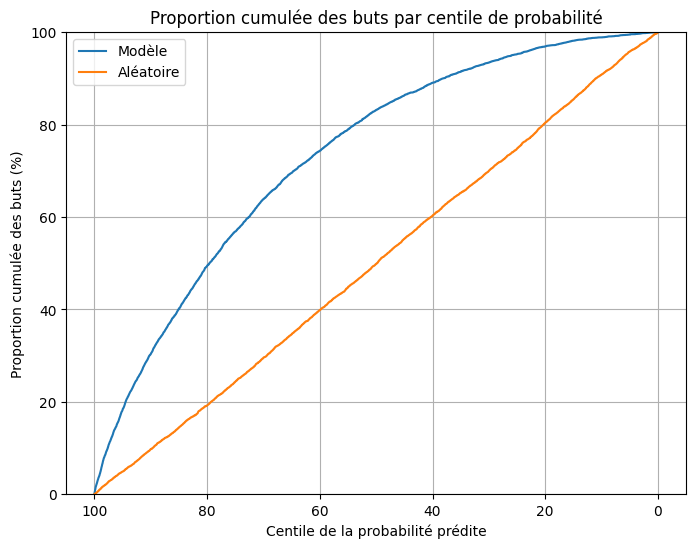

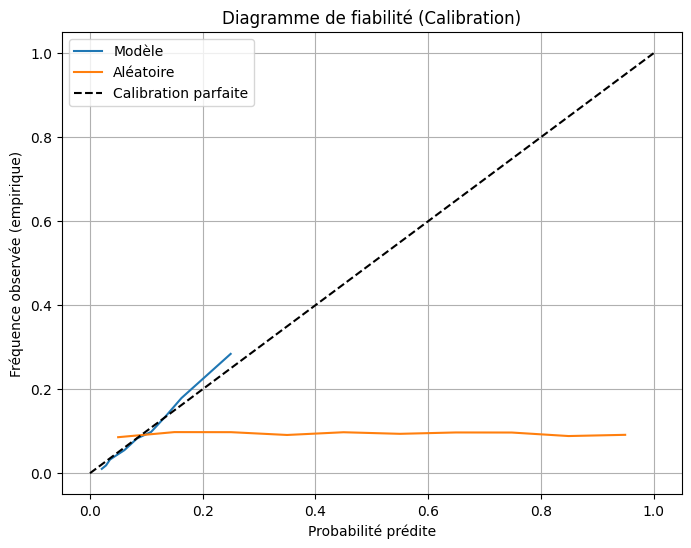

In [17]:
# Generate a random baseline (uniform probabilities)
np.random.seed(42)
prob_random = np.random.uniform(0, 1, len(y_validate))

# **1. ROC Curve and AUC**
plt.figure(figsize=(8, 6))
for name, prob in [
    ("Modèle", y_pred_probs),
    ("Aléatoire", prob_random),
]:
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_validate, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.grid()
plt.show()

# **2. Goal Rate by Probability Percentile**
plt.figure(figsize=(8, 6))
for name, prob in [
    ("Modèle", y_pred_probs),
    ("Aléatoire", prob_random),
]:
    # Sort probabilities and corresponding labels
    sorted_indices = np.argsort(prob)
    prob_sorted = np.array(prob[sorted_indices])
    y_sorted = np.array(y_validate[sorted_indices])

    # Compute goal rates by percentile
    percentiles = np.percentile(prob_sorted, np.arange(0, 101, 10))
    goal_rates = [
        y_sorted[(prob_sorted >= percentiles[i]) & (prob_sorted < percentiles[i + 1])].mean()
        if np.sum((prob_sorted >= percentiles[i]) & (prob_sorted < percentiles[i + 1])) > 0
        else 0
        for i in range(len(percentiles) - 1)
    ]
    plt.plot(np.arange(0, 100, 10), [rate * 100 for rate in goal_rates], label=name)

plt.xlabel("Centile de la probabilité prédite")
plt.ylabel("Taux de buts (%)")
plt.title("Taux de buts par centile de probabilité")
plt.ylim(0, 100)
plt.grid()
plt.legend()
plt.gca().invert_xaxis()  # Reverse the X-axis to go from 100% to 0%
plt.show()

# **3. Cumulative Goal Proportion**
plt.figure(figsize=(8, 6))
for name, prob in [
    ("Modèle", y_pred_probs),
    ("Aléatoire", prob_random),
]:
    # Sort probabilities in descending order
    sorted_indices = np.argsort(prob)[::-1]
    y_sorted = np.array(y_validate)[sorted_indices]

    # Compute cumulative goal proportion
    cumulative_goals = np.cumsum(y_sorted)
    total_goals = np.sum(y_sorted)

    cumulative_goal_proportion = cumulative_goals / total_goals

    # Percentiles
    centiles = np.linspace(100, 0, len(cumulative_goal_proportion))
    plt.plot(centiles, cumulative_goal_proportion * 100, label=name)

plt.xlabel("Centile de la probabilité prédite")
plt.ylabel("Proportion cumulée des buts (%)")
plt.title("Proportion cumulée des buts par centile de probabilité")
plt.ylim(0, 100)
plt.grid()
plt.legend()
plt.gca().invert_xaxis()
plt.show()


# **4. Calibration Curve**
plt.figure(figsize=(8, 6))
for name, prob in [
    ("Modèle", y_pred_probs),
    ("Aléatoire", prob_random),
]:
    # Compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_validate, prob, n_bins=10, strategy="quantile"
    )
    plt.plot(mean_predicted_value, fraction_of_positives, label=name)

# Add a diagonal line for perfect calibration
plt.plot([0, 1], [0, 1], "k--", label="Calibration parfaite")
plt.xlabel("Probabilité prédite")
plt.ylabel("Fréquence observée (empirique)")
plt.title("Diagramme de fiabilité (Calibration)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Log metric to WandB
wandb.log({"roc_auc": roc_auc})


# Finish WandB session
wandb.finish()

roc_auc,▁
train_accuracy,▁
val_accuracy,▁
roc_auc,0.75691
train_accuracy,0.9083
val_accuracy,0.90643


<Figure size 640x480 with 0 Axes>

source: chatgpt